In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import sys,os
import numpy as np

In [3]:
from scipy.optimize import curve_fit

In [4]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.25)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [5]:
import mdtraj as md

## Temperature Replica exchange

In [6]:
def tanh_function(x, p0, p1, p2, p3):
    #return np.abs(p0) + np.abs(p1)*(np.tanh(p2-x) + (1 - np.tanh(p3-x)) + 1)/2 
    # lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    return 0.5*(p0+p1) + 0.5*(p1 - p0)*np.tanh((np.abs(x) - p2)/p3)

def critical_temp(x, Tc, A):
    """
    $ \rho_h - \rho_l = A*(T_c - T)^\beta $
    """
    return A*(Tc - x)**0.325

def rectilinear(x, rhoc, C):
    """
    $ (\rho_h + \rho_l)/2 = \rho_c + C*(T_c - T) $
    """
    return np.abs(rhoc) + np.abs(C)*x

## GSY

In [7]:
%%bash

perl /usr/local/gromacs/2024.1/bin/demux.pl ../data/rep0/soup_XXL_amber99sb-star-ildnTRUE_tip3p_replex.log

mv replica_index.xvg soup_XXL_replica_index.xvg
mv replica_temp.xvg soup_XXL_replica_temp.xvg

-----------------------------------------------------------------
Going to read a file containing the exchange information from
your mdrun log file (../data/rep0/soup_XXL_amber99sb-star-ildnTRUE_tip3p_replex.log).
This will produce a file (replica_index.xvg) suitable for
demultiplexing your trajectories using trjcat,
as well as a replica temperature file (replica_temp.xvg).
Each entry in the log file will be copied 0 times.
-----------------------------------------------------------------
There are 48 replicas.
Finished writing replica_index.xvg and replica_temp.xvg with 250000 lines


In [8]:
temps = np.loadtxt("temps.dat")


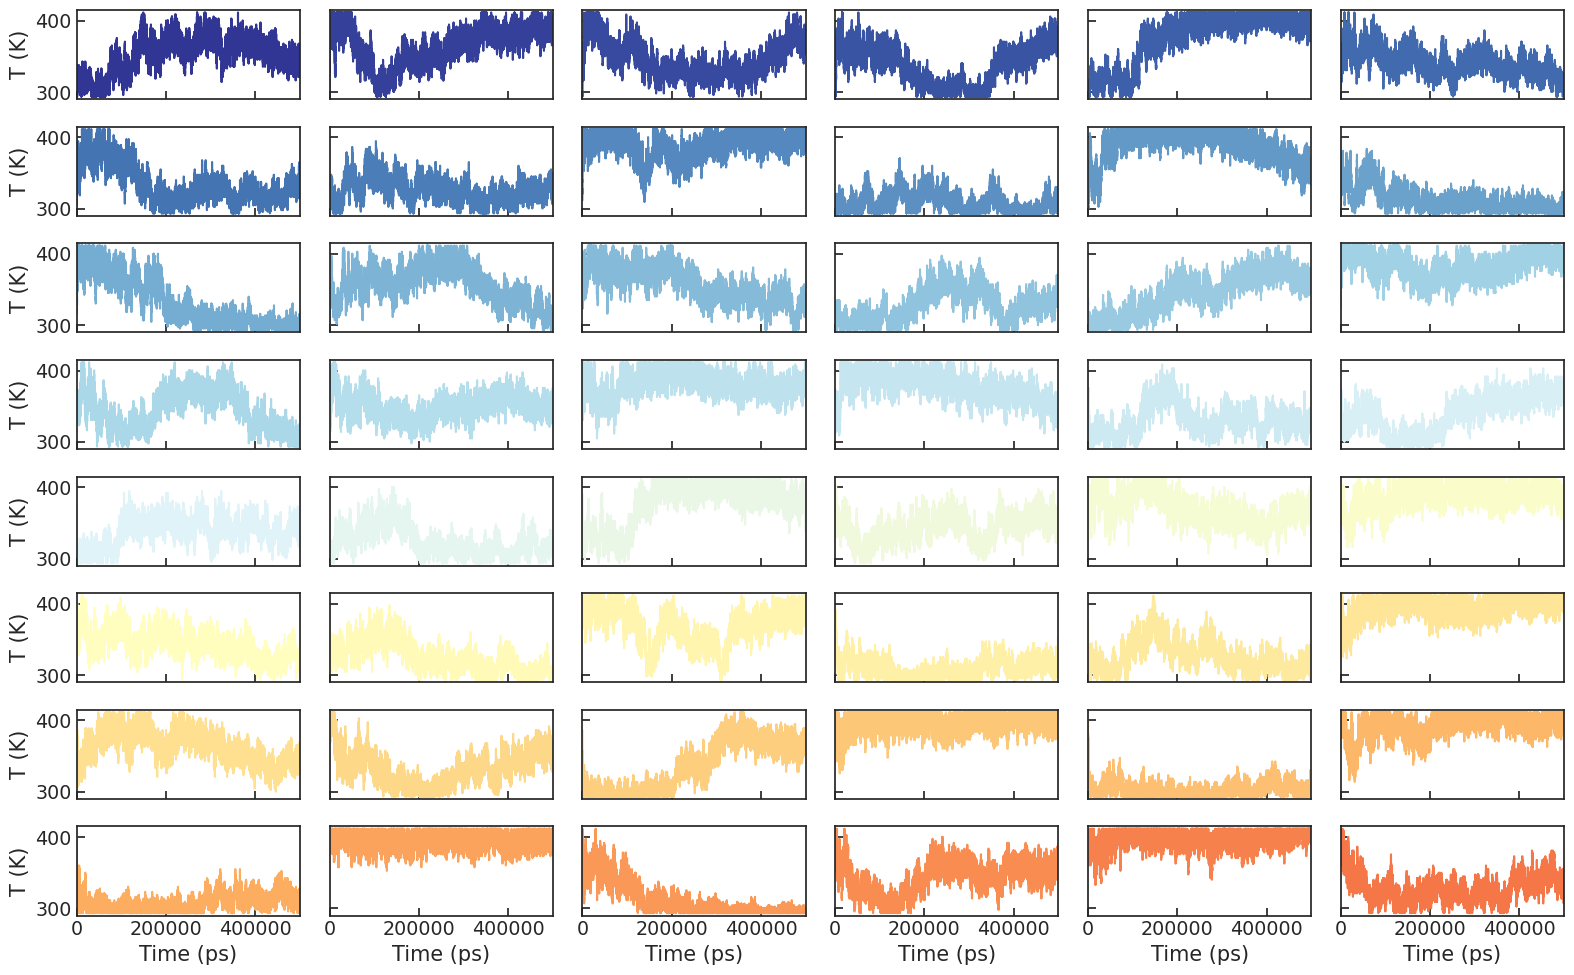

In [18]:
data = np.loadtxt("soup_XXL_replica_temp.xvg", comments=["#", "@"])

fig, ax = plt.subplots(8,6,figsize=(16,10), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(48):
    ax[i].plot(data[:,0], [temps[int(l)] for l in data[:,i+1]], color=plt.cm.RdYlBu_r(i/60))

ax[-1].set_xlim(0,500000)
ax[0].set_ylim(290,415)
[ax[i].set_xlabel('Time (ps)') for i in range(-1,-7,-1)]
[ax[i*6].set_ylabel('T (K)') for i in range(8)]
plt.tight_layout()

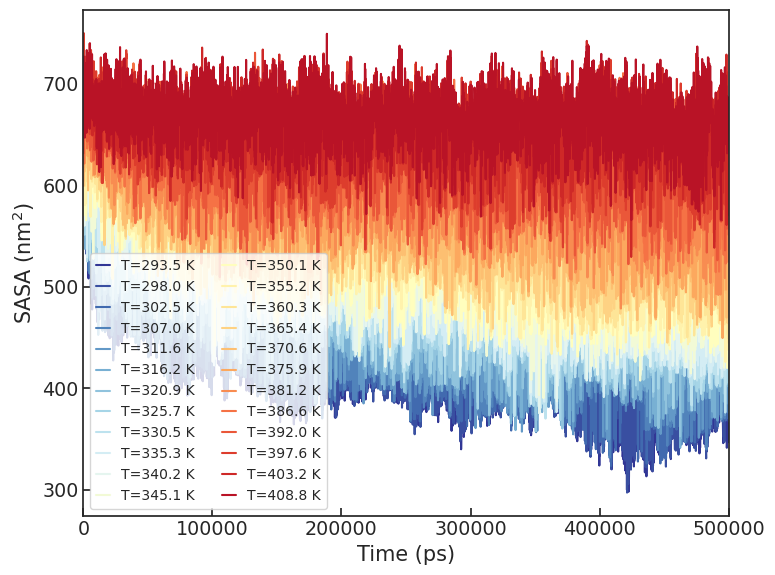

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(0,48,2):
    try:
        data = np.loadtxt("../analysis/soup_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_sasa.xvg"%i, comments=["#", "@"])
        ax.plot(data[:,0], data[:,1], color=plt.cm.RdYlBu_r(i/48), label='T=%.1f K'%temps[i])

    except Exception as e:
        print (e)
        pass
ax.set_xlim(0,500000)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('SASA (nm$^2$)')
ax.legend(loc=3, fontsize=10, handlelength=1, ncol=2)
plt.tight_layout()

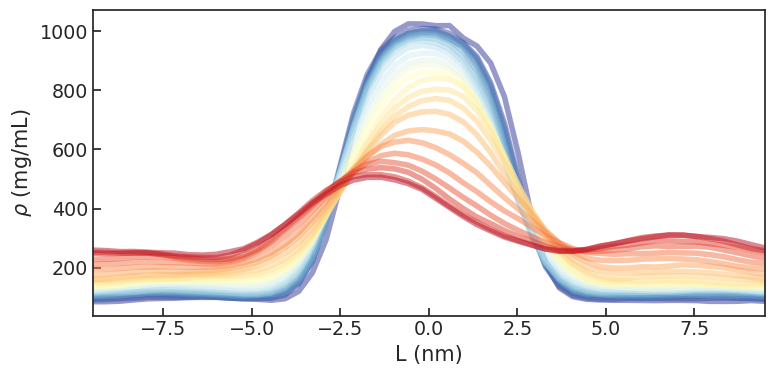

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,4), sharex=True)
for i in range(0, 48,  2):
    try:
        data = np.loadtxt("../analysis/soup_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_density.xvg"%i, comments=["#", "@"])
        ax.plot(data[:,0], data[:,1], color=plt.cm.RdYlBu_r(i/48), label='T=%.1f K'%temps[i], lw=4, alpha=0.5)      

    except Exception as e:
        print (e)

        pass
ax.set_xlim(data[0,0], data[-1,0])
#ax.set_ylim(-1,60
ax.set_xlabel('L (nm)')
ax.set_ylabel(r'$\rho$ (mg/mL)')
#ax.legend(loc=3, fontsize=10, handlelength=1, ncol=2)
#ax.set_ylim(700,1400)
plt.tight_layout(w_pad=0)
plt.savefig("figures/soup_XXL_replex_density.png", dpi=300, transparent=True)

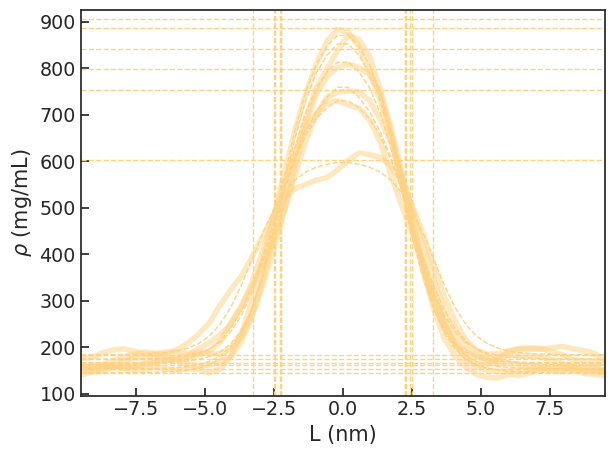

In [43]:
rho_vals_gsy = []
p0=[90, 1000,  2.5,  -1]

fig, ax = plt.subplots()
for i in [30]: #range(48):
    rho_err = []
    for j in range(6):
        try:
            data = np.loadtxt("../analysis/soup_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_density_bin%i.xvg"%(i,j), comments=["#", "@"])
            ax.plot(data[:,0], data[:,1], color=plt.cm.RdYlBu_r(i/48), label='T=%.1f K'%temps[i], lw=4, alpha=0.5)      
            popt, pcov = curve_fit(tanh_function, data[:,0], data[:,1], \
                    p0=p0)
            ax.plot(data[:,0], tanh_function(data[:,0], *popt), color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')
            rho_err.append([popt[0], popt[1]])
            ax.axhline(popt[0], color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')
            ax.axhline(popt[1], color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')
            ax.axvline(popt[2], color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')
            ax.axvline(-popt[2], color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')

            #print (popt)
        except Exception as e:
            print (e)
    break
        
ax.set_xlim(data[0,0], data[-1,0])
#ax.set_ylim(-1,60
#ax.set_xlabel('L (nm)')
#ax.set_ylabel(r'$\rho$ (mg/mL)')
#ax.legend(loc=3, fontsize=10, handlelength=1, ncol=2)
#ax.set_ylim(700,1400)
#ax[-1].set_xlim(0,130000)
# ax[0].set_ylim(290,415)
ax.set_xlabel('L (nm)')
ax.set_ylabel(r'$\rho$ (mg/mL)')
plt.tight_layout()

<function matplotlib.pyplot.savefig(*args, **kwargs) -> 'None'>

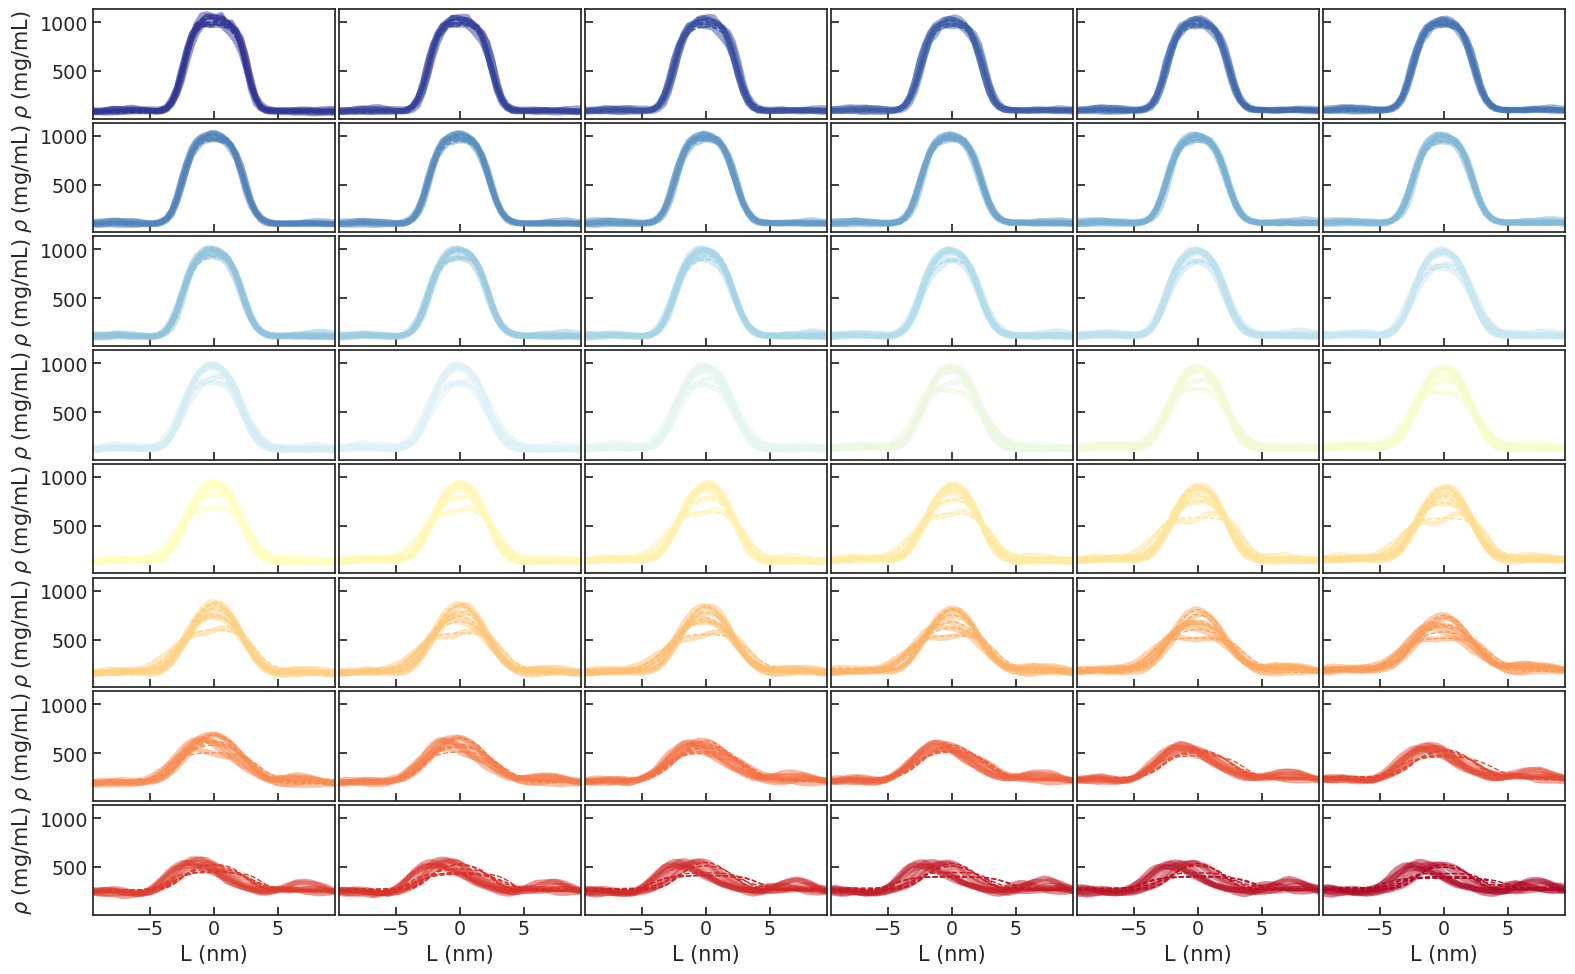

In [21]:
rho_vals_gsy = []
p0=[90, 1000, 2.5, -1]

fig, ax = plt.subplots(8,6, figsize=(16,10), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(48):
    rho_err = []
    for j in range(6):
        try:
            data = np.loadtxt("../analysis/soup_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_density_bin%i.xvg"%(i,j), comments=["#", "@"])
            ax[i].plot(data[:,0], data[:,1], color=plt.cm.RdYlBu_r(i/48), label='T=%.1f K'%temps[i], lw=4, alpha=0.5)      
            popt, pcov = curve_fit(tanh_function, data[:,0], data[:,1], \
                    p0=p0)
            ax[i].plot(data[:,0], tanh_function(data[:,0], *popt), color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')
            rho_err.append([popt[0], popt[1]])
            #print (popt)
        except Exception as e:
            print (e)
        
    rho_vals_gsy.append([np.mean(rho_err, axis=0), np.std(rho_err, axis=0)])

ax[0].set_xlim(data[0,0], data[-1,0])
#ax.set_ylim(-1,60
#ax.set_xlabel('L (nm)')
#ax.set_ylabel(r'$\rho$ (mg/mL)')
#ax.legend(loc=3, fontsize=10, handlelength=1, ncol=2)
#ax.set_ylim(700,1400)
#ax[-1].set_xlim(0,130000)
# ax[0].set_ylim(290,415)
[ax[i].set_xlabel('L (nm)') for i in range(-1,-7,-1)]
[ax[i*6].set_ylabel(r'$\rho$ (mg/mL)') for i in range(8)]
plt.tight_layout()
plt.tight_layout(w_pad=0.2, h_pad=0.2)
plt.savefig

Tc=389.865; A=221.256


/tmp/ipykernel_3542681/835360053.py:10: RuntimeWarning: invalid value encountered in power
  return A*(Tc - x)**0.325


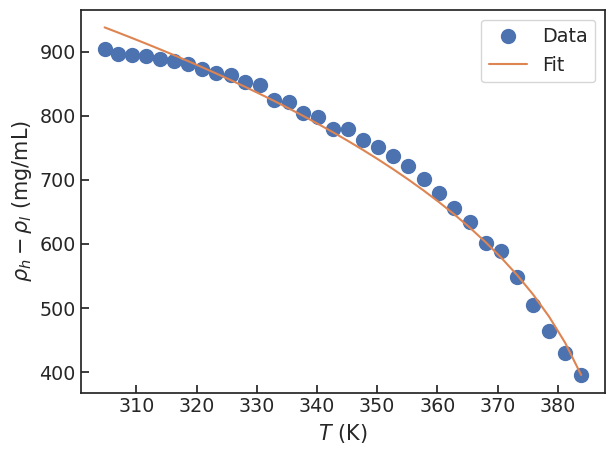

In [25]:
xvals = np.array(temps)[5:-10]
yvals = np.array([x[0][1]-x[0][0] for x in rho_vals_gsy])[5:-10]

popt, pcov = curve_fit(critical_temp, xvals, yvals, p0=[420,100])
print ("Tc=%g; A=%g"%(popt[0], popt[1]))
Tc_gsy = popt[0]
A_gsy = popt[1]

plt.plot(xvals, yvals, 'o', label='Data', ms=10)
plt.plot(xvals, critical_temp(xvals, popt[0], popt[1]), '-', label='Fit')
plt.xlabel('$T$ (K)')
plt.ylabel(r'$\rho_h - \rho_l$ (mg/mL)')
plt.legend(loc=1)
plt.tight_layout()

rhoc=406.902; C=2.72323


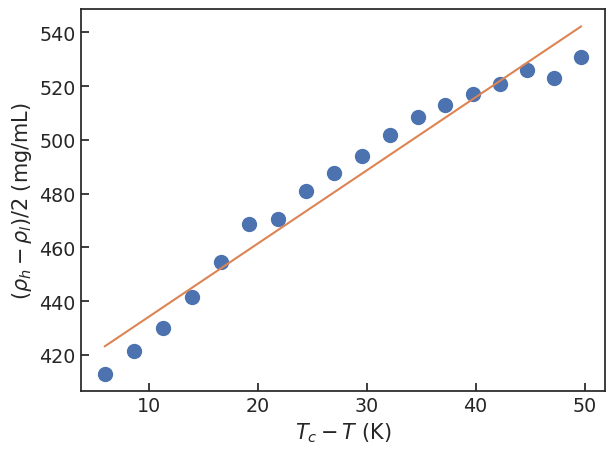

In [26]:
xvals = Tc_gsy - np.array(temps)[20:-10]
yvals = np.array([0.5*(x[0][1]+x[0][0]) for x in rho_vals_gsy])[20:-10]
popt, pcov = curve_fit(rectilinear, xvals, yvals, p0=[430,10])
print ("rhoc=%g; C=%g"%(popt[0], popt[1]))
rhoc_gsy = popt[0]
C_gsy = popt[1]

plt.plot(xvals, yvals, 'o', label='Data', ms=10)
plt.plot(xvals, rectilinear(xvals, popt[0], popt[1]), '-')
plt.xlabel('$T_c - T$ (K)')
plt.ylabel(r'$(\rho_h - \rho_l)/2$ (mg/mL)')
plt.tight_layout()


In [27]:
tvals_gsy = np.linspace(350,Tc_gsy, 100)
rhoh_gsy = 0.5*(critical_temp(tvals_gsy, Tc_gsy, A_gsy) + 2*rectilinear(Tc_gsy - tvals_gsy, rhoc_gsy, np.abs(C_gsy)))
rhol_gsy = rhoh_gsy -  critical_temp(tvals_gsy, Tc_gsy, A_gsy)

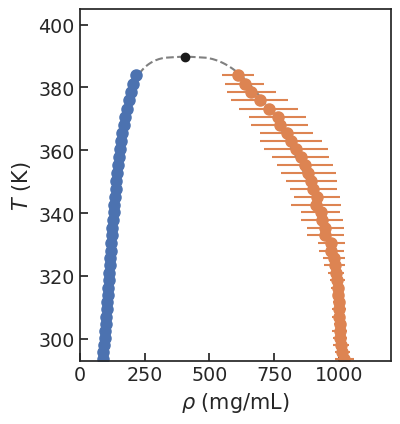

In [28]:
plt.subplots(figsize=(4.5,4.5))
plt.errorbar([x[0][0] for x in rho_vals_gsy[:-10]], temps[:-10], xerr=[x[1][0] for x in rho_vals_gsy[:-10]], fmt='o', ms=8)
plt.errorbar([x[0][1] for x in rho_vals_gsy[:-10]], temps[:-10], xerr=[x[1][1] for x in rho_vals_gsy[:-10]], fmt='o', ms=8)

plt.plot(rhoh_gsy, tvals_gsy, '--', color='gray')
plt.plot(rhol_gsy, tvals_gsy, '--', color='gray')
plt.plot(rhoc_gsy, Tc_gsy, 'o', color='k')

plt.xlabel(r'$\rho$ (mg/mL)')
plt.ylabel('$T$ (K)')
plt.ylim(293,405)
plt.xlim(0,1200)
plt.tight_layout()

## GSF

In [21]:
%%bash

perl /usr/local/gromacs/2024.1/bin/demux.pl ../data/rep0/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_replex.log

mv replica_index.xvg soupF_XXL_replica_index.xvg
mv replica_temp.xvg soupF_XXL_replica_temp.xvg

-----------------------------------------------------------------
Going to read a file containing the exchange information from
your mdrun log file (../data/rep0/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_replex.log).
This will produce a file (replica_index.xvg) suitable for
demultiplexing your trajectories using trjcat,
as well as a replica temperature file (replica_temp.xvg).
Each entry in the log file will be copied 0 times.
-----------------------------------------------------------------
There are 48 replicas.
Finished writing replica_index.xvg and replica_temp.xvg with 205343 lines


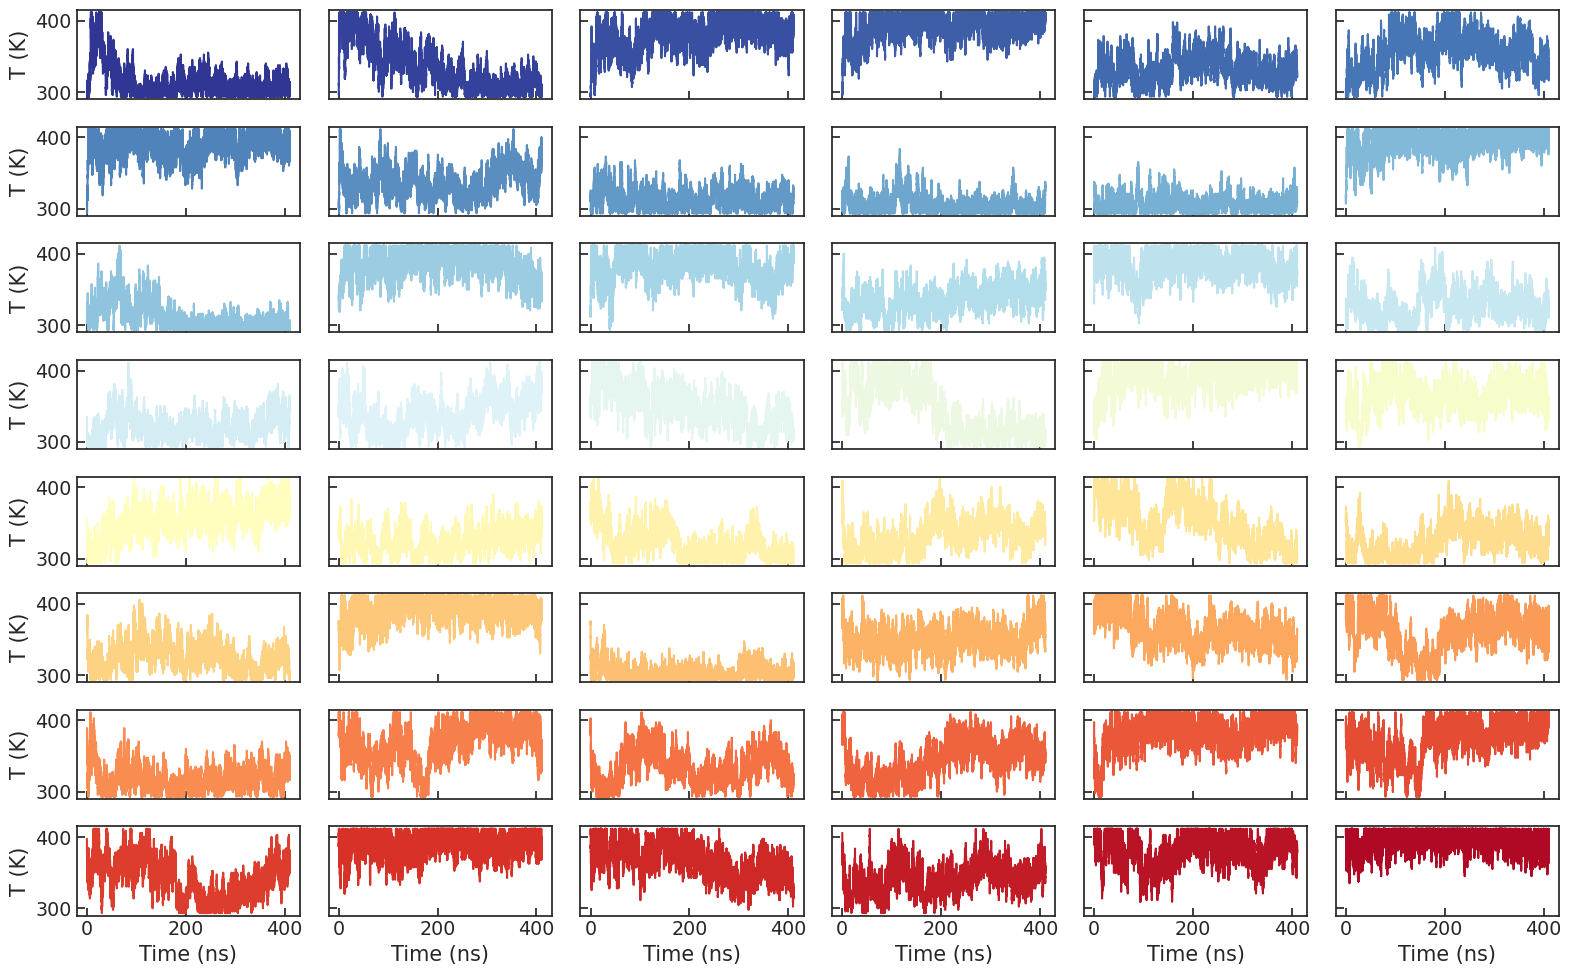

In [29]:
data = np.loadtxt("soupF_XXL_replica_temp.xvg", comments=["#", "@"])
temps = np.loadtxt("temps.dat")

fig, ax = plt.subplots(8,6,figsize=(16,10), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(48):
    ax[i].plot(data[:,0]*1e-3, [temps[int(l)] for l in data[:,i+1]], color=plt.cm.RdYlBu_r(i/48))

#ax[-1].set_xlim(0,500000)
ax[0].set_ylim(290,415)
[ax[i].set_xlabel('Time (ns)') for i in range(-1,-7,-1)]
[ax[i*6].set_ylabel('T (K)') for i in range(8)]
plt.tight_layout()

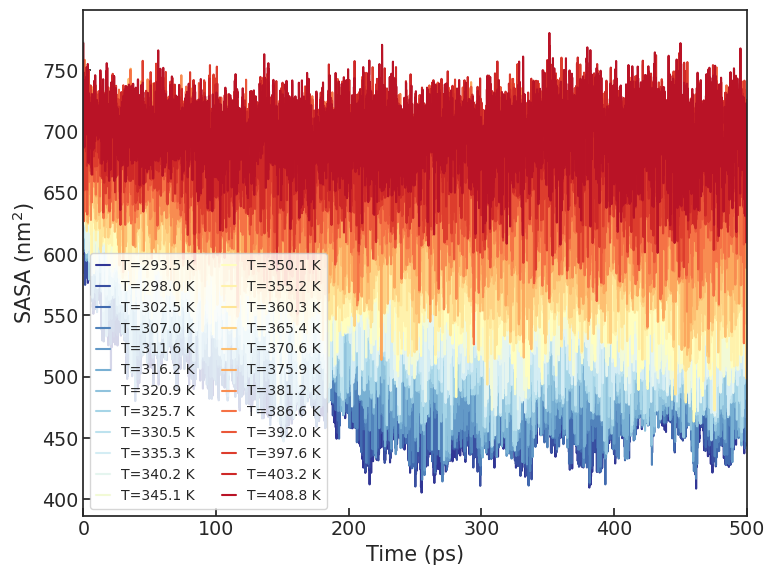

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(0,48,2):
    try:
        data = np.loadtxt("../analysis/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_sasa.xvg"%i, comments=["#", "@"])
        ax.plot(data[:,0]*1e-3, data[:,1], color=plt.cm.RdYlBu_r(i/48), label='T=%.1f K'%temps[i])

    except Exception as e:
        print (e)
        pass
ax.set_xlim(0,500)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('SASA (nm$^2$)')
ax.legend(loc=3, fontsize=10, handlelength=1, ncol=2)
plt.tight_layout()

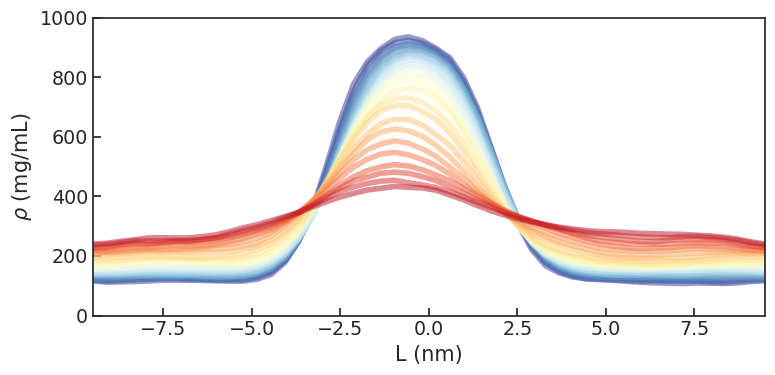

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,4), sharex=True)
for i in range(0, 48,  2):
    try:
        data = np.loadtxt("../analysis/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_density.xvg"%i, comments=["#", "@"])
        ax.plot(data[:,0], data[:,1], color=plt.cm.RdYlBu_r(i/48), label='T=%.1f K'%temps[i], lw=4, alpha=0.5)      
        #popt, pcov = curve_fit(tanh_function, data[:,0], data[:,1], p0=p0)
        #ax.plot(data[:,0], tanh_function(data[:,0], *popt), color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')
        #rho_vals.append([popt[0], popt[1]])

    except Exception as e:
        print (e)

        pass
ax.set_xlim(data[0,0], data[-1,0])
#ax.set_ylim(-1,60
ax.set_xlabel('L (nm)')
ax.set_ylabel(r'$\rho$ (mg/mL)')
#ax.legend(loc=3, fontsize=10, handlelength=1, ncol=2)
ax.set_ylim(00,1000)
plt.tight_layout(w_pad=0)
plt.savefig("figures/soupF_XXL_replex_density.png", dpi=300, transparent=True)

Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


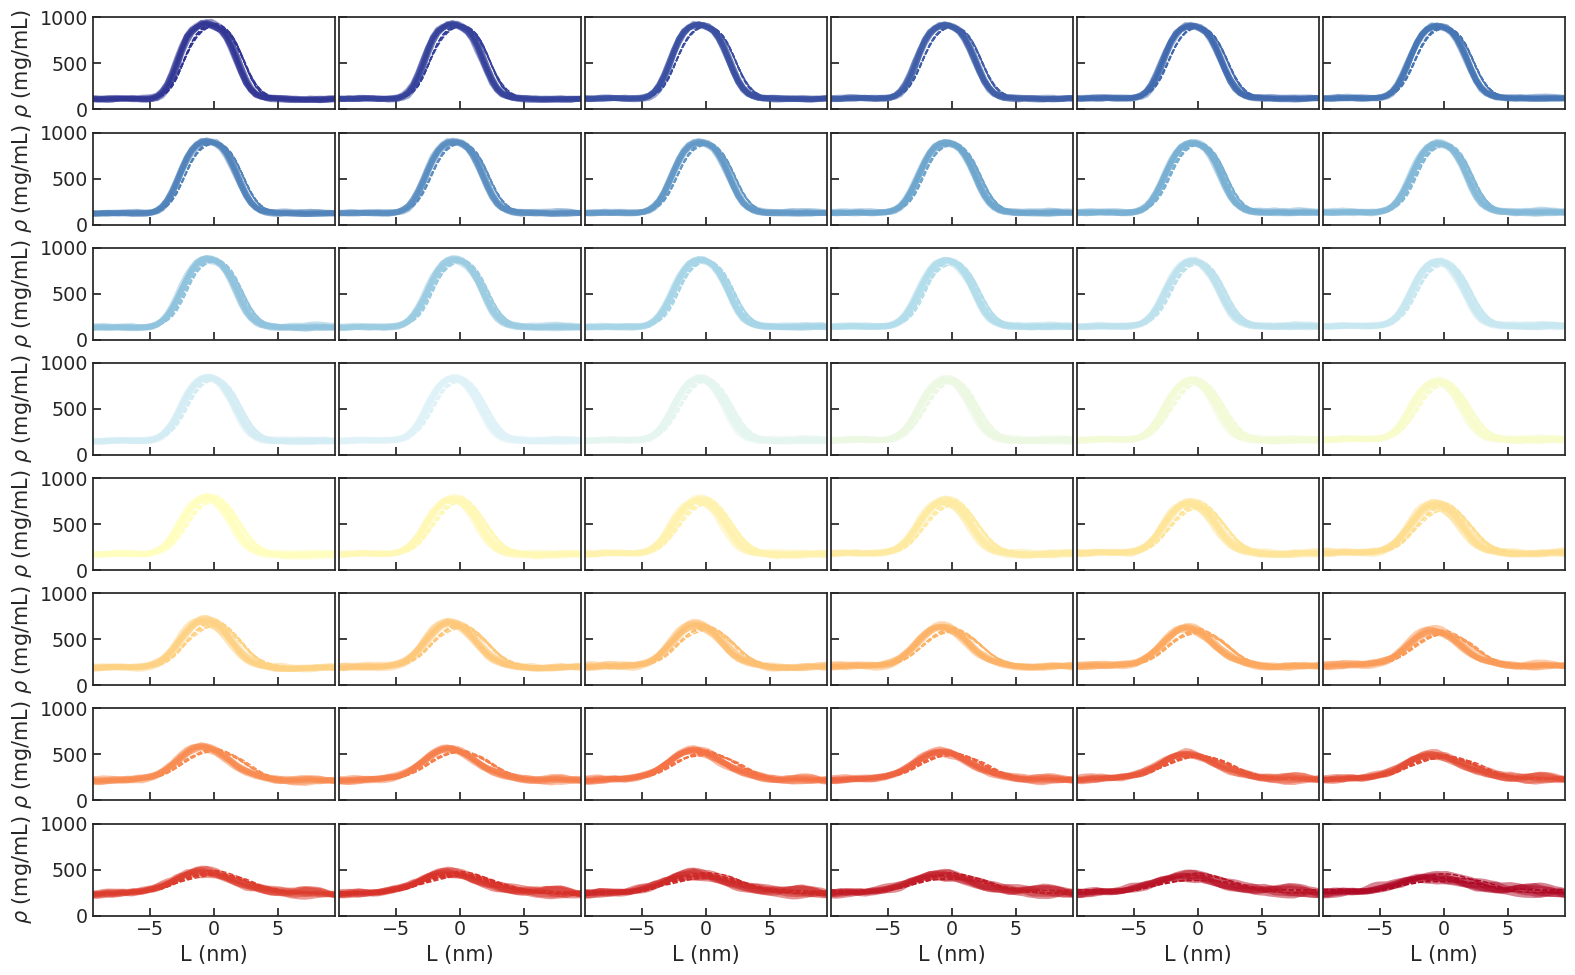

In [32]:
rho_vals_gsf = []
p0=[90, 1000,  2.5,  -1]
fig, ax = plt.subplots(8,6, figsize=(16,10), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(48):
    rho_err = []
    for j in range(6):
        try:
            data = np.loadtxt("../analysis/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_density_bin%i.xvg"%(i,j), comments=["#", "@"])
            ax[i].plot(data[:,0], data[:,1], color=plt.cm.RdYlBu_r(i/48), label='T=%.1f K'%temps[i], lw=4, alpha=0.5)      
            popt, pcov = curve_fit(tanh_function, data[:,0], data[:,1], \
                    p0=p0)
            ax[i].plot(data[:,0], tanh_function(data[:,0], *popt), color=plt.cm.RdYlBu_r(i/48), lw=1, ls='--')
            rho_err.append([popt[0], popt[1]])
            #print (popt)
        except Exception as e:
            print (e)        
    rho_vals_gsf.append([np.mean(rho_err, axis=0), np.std(rho_err, axis=0)])

ax[0].set_xlim(data[0,0], data[-1,0])
ax[0].set_ylim(0,1000)
[ax[i].set_xlabel('L (nm)') for i in range(-1,-7,-1)]
[ax[i*6].set_ylabel(r'$\rho$ (mg/mL)') for i in range(8)]
plt.tight_layout()
plt.tight_layout(w_pad=0.2, h_pad=0.2)

Tc=386.377; A=194.992


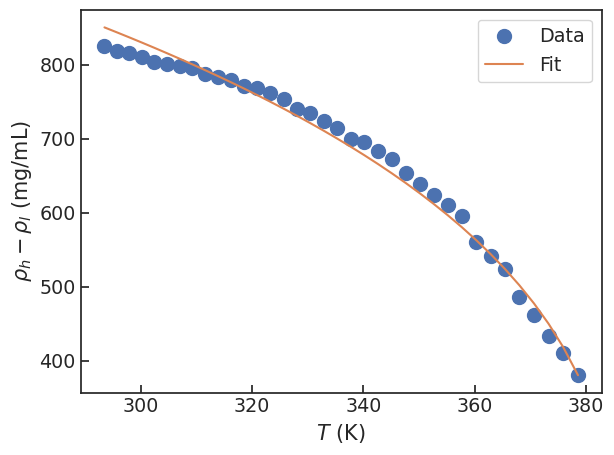

In [33]:
xvals = np.array(temps)[:-12]
yvals = np.array([x[0][1]-x[0][0] for x in rho_vals_gsf])[:-12]

popt, pcov = curve_fit(critical_temp, xvals, yvals, p0=[380,100])
print ("Tc=%g; A=%g"%(popt[0], popt[1]))
Tc_gsf = popt[0]
A_gsf = popt[1]

plt.plot(xvals, yvals, 'o', label='Data', ms=10)
plt.plot(xvals, critical_temp(xvals, popt[0], popt[1]), '-', label='Fit')
plt.xlabel('$T$ (K)')
plt.ylabel(r'$\rho_h - \rho_l$ (mg/mL)')
plt.legend(loc=1)
plt.tight_layout()

rhoc=405.223; C=1.93346


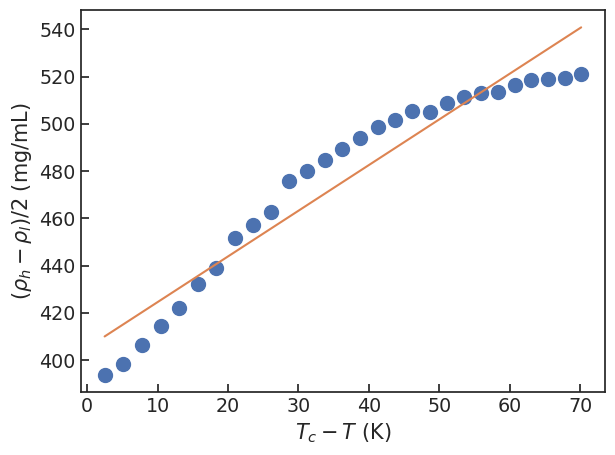

In [34]:
xvals = Tc_gsf - np.array(temps)[10:-10]
yvals = np.array([0.5*(x[0][1]+x[0][0]) for x in rho_vals_gsf])[10:-10]
popt, pcov = curve_fit(rectilinear, xvals, yvals, p0=[430,10])
print ("rhoc=%g; C=%g"%(popt[0], popt[1]))
rhoc_gsf = popt[0]
C_gsf = popt[1]

plt.plot(xvals, yvals, 'o', label='Data', ms=10)
plt.plot(xvals, rectilinear(xvals, popt[0], popt[1]), '-')
plt.xlabel('$T_c - T$ (K)')
plt.ylabel(r'$(\rho_h - \rho_l)/2$ (mg/mL)')
plt.tight_layout()


In [35]:
tvals_gsf = np.linspace(350, Tc_gsf, 50)
rhoh_gsf = 0.5*(critical_temp(tvals_gsf, Tc_gsf, A_gsf) + 2*rectilinear(Tc_gsf - tvals_gsf, rhoc_gsf, np.abs(C_gsf)))
rhol_gsf = rhoh_gsf -  critical_temp(tvals_gsf, Tc_gsf, A_gsf)

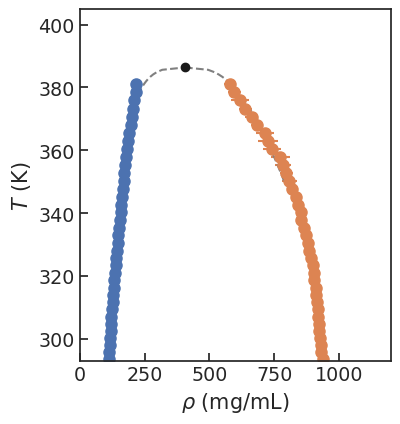

In [36]:
plt.subplots(figsize=(4.5,4.5))
plt.errorbar([x[0][0] for x in rho_vals_gsf[:-11]], temps[:-11], xerr=[x[1][0] for x in rho_vals_gsf[:-11]], fmt='o', ms=8)
plt.errorbar([x[0][1] for x in rho_vals_gsf[:-11]], temps[:-11], xerr=[x[1][1] for x in rho_vals_gsf[:-11]], fmt='o', ms=8)

plt.plot(rhoh_gsf, tvals_gsf, '--', color='gray')
plt.plot(rhol_gsf, tvals_gsf, '--', color='gray')
plt.plot(rhoc_gsf, Tc_gsf, 'o', color='k')

plt.xlabel(r'$\rho$ (mg/mL)')
plt.ylabel('$T$ (K)')
plt.ylim(293,405)
plt.xlim(0,1200)
plt.tight_layout()

/tmp/ipykernel_3127669/3584454150.py:31: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,1100)


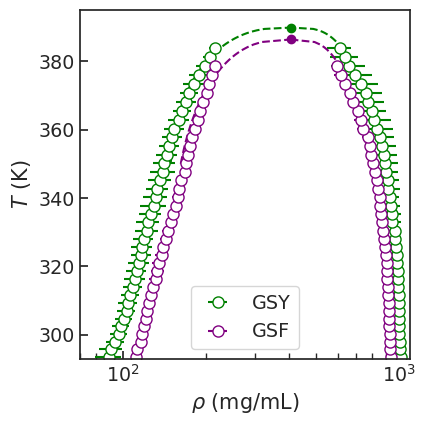

In [87]:
plt.subplots(figsize=(4.5,4.5))

plt.errorbar([x[0][0] for x in rho_vals_gsy[:-10]], temps[:-10], \
             xerr=[x[1][0] for x in rho_vals_gsy[:-10]], fmt='o', \
                ms=8, mec='green', ecolor='green', mfc='white',
             label='GSY')
plt.errorbar([x[0][1] for x in rho_vals_gsy[:-10]], temps[:-10], \
             xerr=[x[1][1] for x in rho_vals_gsy[:-10]], fmt='o', \
                ms=8, mec='green', ecolor='green', mfc='white')

plt.plot(rhoh_gsy, tvals_gsy, '--', color='green')
plt.plot(rhol_gsy, tvals_gsy, '--', color='green')
plt.plot(rhoc_gsy, Tc_gsy, 'o', color='green')

plt.errorbar([x[0][0] for x in rho_vals_gsf[:-12]], temps[:-12],\
        xerr=[x[1][0] for x in rho_vals_gsf[:-12]], fmt='o', \
        ms=8, mec='purple', ecolor='purple',mfc='white', \
        label='GSF')
plt.errorbar([x[0][1] for x in rho_vals_gsf[:-12]], temps[:-12], \
        xerr=[x[1][1] for x in rho_vals_gsf[:-12]], fmt='o', \
        ms=8, mec='purple', ecolor='purple',mfc='white')

plt.plot(rhoh_gsf, tvals_gsf, '--', color='purple')
plt.plot(rhol_gsf, tvals_gsf, '--', color='purple')
plt.plot(rhoc_gsf, Tc_gsf, 'o', color='purple')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\rho$ (mg/mL)')
plt.ylabel('$T$ (K)')
plt.ylim(293,395)
plt.xlim(0,1100)
plt.tight_layout()
plt.savefig("figures/phase_diagram_FvsY.png", dpi=300)

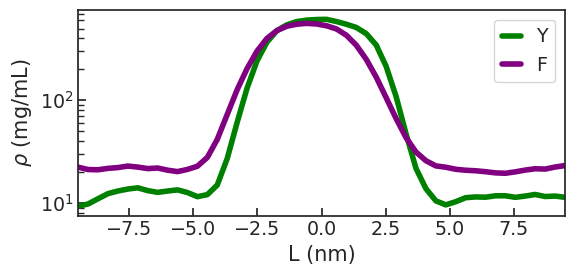

In [93]:
fig, ax = plt.subplots(figsize=(6,3))
i = 2
data = np.loadtxt("../analysis/soup_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_densityX.xvg"%i, comments=["#", "@"])
ax.plot(data[:,0], data[:,1], color='green', lw=4, label='Y')
data = np.loadtxt("../analysis/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_rep%i_densityX.xvg"%i, comments=["#", "@"])
ax.plot(data[:,0], data[:,1], color='purple', lw=4, label='F')

ax.set_xlim(data[0,0], data[-1,0])
ax.set_yscale('log')
ax.set_xlabel('L (nm)')
ax.set_ylabel(r'$\rho$ (mg/mL)') 
plt.legend(loc=1, handlelength=1)

plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig("figures/density_stickers_only.png", dpi=300)